# Telstra Network Disruptions 

The goal of the problem is to predict Telstra network's fault severity at a time at a particular location based on the log data available. Each row in the main dataset (train.csv, test.csv) represents a location and a time point. They are identified by the "id" column, which is the key "id" used in other data files. 

Fault severity has 3 categories: 0,1,2 (0 meaning no fault, 1 meaning only a few, and 2 meaning many). 

Different types of features are extracted from log files and other sources: event_type.csv, log_feature.csv, resource_type.csv, severity_type.csv. 

Note: “severity_type” is a feature extracted from the log files (in severity_type.csv). Often this is a severity type of a warning message coming from the log. "severity_type" is categorical. It does not have an ordering. “fault_severity” is a measurement of actual reported faults from users of the network and is the target variable (in train.csv).

File descriptions
- train.csv - el conjunto de entrenamiento para la severidad de la falla
- test.csv - el conjunto de prueba para la severidad de la falla
- sample_submission.csv – una muestra del formato correcto para la entrada
- event_type.csv: tipo de evento relacionado con el conjunto de datos principal
- log_feature.csv - características extraídas de los archivos de registro
- resource_type.csv: tipo de recurso relacionado con el conjunto de datos principal
- severity_type.csv: tipo de severidad de un mensaje de advertencia que proviene delregistro

# Importamos librerías y datos:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

%matplotlib inline
sns.set()

In [2]:
train = pd.read_csv('train.csv')
train.head()

,id,location,fault_severity
0,14121,location 118,1
1,9320,location 91,0
2,14394,location 152,1
3,8218,location 931,1
4,14804,location 120,0


In [3]:
test= pd.read_csv('test.csv')
test.head()

,id,location
0,11066,location 481
1,18000,location 962
2,16964,location 491
3,4795,location 532
4,3392,location 600


In [4]:
sample= pd.read_csv('sample_submission.csv')
sample.head()

,id,predict_0,predict_1,predict_2
0,11066,0,1,0
1,18000,0,1,0
2,16964,0,1,0
3,4795,0,1,0
4,3392,0,1,0


In [5]:
sample.tail()

,id,predict_0,predict_1,predict_2
11166,14806,0,1,0
11167,1825,0,1,0
11168,2374,0,1,0
11169,7277,0,1,0
11170,9886,0,1,0


In [6]:
event= pd.read_csv('event_type.csv')
event.head()

,id,event_type
0,6597,event_type 11
1,8011,event_type 15
2,2597,event_type 15
3,5022,event_type 15
4,5022,event_type 11


In [7]:
log_feature= pd.read_csv('log_feature.csv')
log_feature.head()

,id,log_feature,volume
0,6597,feature 68,6
1,8011,feature 68,7
2,2597,feature 68,1
3,5022,feature 172,2
4,5022,feature 56,1


In [8]:
resource_type= pd.read_csv('resource_type.csv')
resource_type.head()

,id,resource_type
0,6597,resource_type 8
1,8011,resource_type 8
2,2597,resource_type 8
3,5022,resource_type 8
4,6852,resource_type 8


In [9]:
severity_type= pd.read_csv('severity_type.csv')
severity_type.head()

,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2
2,2597,severity_type 2
3,5022,severity_type 1
4,6852,severity_type 1


In [10]:
#Para ver los shapes:
print ('train: ', train.shape)
print ('test: ', test.shape)
print ('sample: ', sample.shape)
print ('event: ', event.shape)
print ('log_feature: ', log_feature.shape)
print ('resource_type: ', resource_type.shape)
print ('severity_type: ', severity_type.shape)

train:  (7381, 3)
test:  (11171, 2)
sample:  (11171, 4)
event:  (31170, 2)
log_feature:  (58671, 3)
resource_type:  (21076, 2)
severity_type:  (18552, 2)


Juntando para **train**:

In [11]:
train1= train.merge(severity_type, how= 'left', left_on='id', right_on='id')
train1.head()

,id,location,fault_severity,severity_type
0,14121,location 118,1,severity_type 2
1,9320,location 91,0,severity_type 2
2,14394,location 152,1,severity_type 2
3,8218,location 931,1,severity_type 1
4,14804,location 120,0,severity_type 1


In [12]:
train2= train1.merge(event, how= 'left', left_on='id', right_on='id')
train2.head()

,id,location,fault_severity,severity_type,event_type
0,14121,location 118,1,severity_type 2,event_type 34
1,14121,location 118,1,severity_type 2,event_type 35
2,9320,location 91,0,severity_type 2,event_type 34
3,9320,location 91,0,severity_type 2,event_type 35
4,14394,location 152,1,severity_type 2,event_type 35


In [13]:
train3= train2.merge(resource_type, how= 'left', left_on='id', right_on='id')
train3.head()

,id,location,fault_severity,severity_type,event_type,resource_type
0,14121,location 118,1,severity_type 2,event_type 34,resource_type 2
1,14121,location 118,1,severity_type 2,event_type 35,resource_type 2
2,9320,location 91,0,severity_type 2,event_type 34,resource_type 2
3,9320,location 91,0,severity_type 2,event_type 35,resource_type 2
4,14394,location 152,1,severity_type 2,event_type 35,resource_type 2


In [14]:
train4= train3.merge(log_feature, how='left', left_on='id', right_on='id')
train4.head(10)

,id,location,fault_severity,severity_type,event_type,resource_type,log_feature,volume
0,14121,location 118,1,severity_type 2,event_type 34,resource_type 2,feature 312,19
1,14121,location 118,1,severity_type 2,event_type 34,resource_type 2,feature 232,19
2,14121,location 118,1,severity_type 2,event_type 35,resource_type 2,feature 312,19
3,14121,location 118,1,severity_type 2,event_type 35,resource_type 2,feature 232,19
4,9320,location 91,0,severity_type 2,event_type 34,resource_type 2,feature 315,200
5,9320,location 91,0,severity_type 2,event_type 34,resource_type 2,feature 235,116
6,9320,location 91,0,severity_type 2,event_type 35,resource_type 2,feature 315,200
7,9320,location 91,0,severity_type 2,event_type 35,resource_type 2,feature 235,116
8,14394,location 152,1,severity_type 2,event_type 35,resource_type 2,feature 221,1
9,14394,location 152,1,severity_type 2,event_type 35,resource_type 2,feature 301,1


Podemos ver que hay registros repetidos, por lo que procedemos a eliminamos de acuerdo al `id`.

In [15]:
train4.drop_duplicates(subset='id', inplace=True)

In [16]:
train4.reset_index(inplace=True, drop=True)

In [17]:
train4.head()

,id,location,fault_severity,severity_type,event_type,resource_type,log_feature,volume
0,14121,location 118,1,severity_type 2,event_type 34,resource_type 2,feature 312,19
1,9320,location 91,0,severity_type 2,event_type 34,resource_type 2,feature 315,200
2,14394,location 152,1,severity_type 2,event_type 35,resource_type 2,feature 221,1
3,8218,location 931,1,severity_type 1,event_type 15,resource_type 8,feature 80,9
4,14804,location 120,0,severity_type 1,event_type 34,resource_type 2,feature 134,1


Podemos ver que no hay registros repetidos, por lo que procedemos a eliminamos de acuerdo al `id`.

In [18]:
train4.shape

(7381, 8)

Junatmos para **test**

In [19]:
test.head()

,id,location
0,11066,location 481
1,18000,location 962
2,16964,location 491
3,4795,location 532
4,3392,location 600


In [20]:
test1= test.merge(severity_type, how= 'left', left_on='id', right_on='id')
test1.head()

,id,location,severity_type
0,11066,location 481,severity_type 2
1,18000,location 962,severity_type 1
2,16964,location 491,severity_type 2
3,4795,location 532,severity_type 5
4,3392,location 600,severity_type 2


In [21]:
test2= test1.merge(event, how= 'left', left_on='id', right_on='id')
test2.head()

,id,location,severity_type,event_type
0,11066,location 481,severity_type 2,event_type 35
1,11066,location 481,severity_type 2,event_type 34
2,18000,location 962,severity_type 1,event_type 11
3,18000,location 962,severity_type 1,event_type 15
4,16964,location 491,severity_type 2,event_type 35


In [22]:
test3= test2.merge(resource_type, how= 'left', left_on='id', right_on='id')
test3.head()

,id,location,severity_type,event_type,resource_type
0,11066,location 481,severity_type 2,event_type 35,resource_type 2
1,11066,location 481,severity_type 2,event_type 34,resource_type 2
2,18000,location 962,severity_type 1,event_type 11,resource_type 8
3,18000,location 962,severity_type 1,event_type 15,resource_type 8
4,16964,location 491,severity_type 2,event_type 35,resource_type 2


In [23]:
test4= test3.merge(log_feature, how='left', left_on='id', right_on='id')
test4.head(10)

,id,location,severity_type,event_type,resource_type,log_feature,volume
0,11066,location 481,severity_type 2,event_type 35,resource_type 2,feature 230,24
1,11066,location 481,severity_type 2,event_type 35,resource_type 2,feature 310,28
2,11066,location 481,severity_type 2,event_type 35,resource_type 2,feature 228,20
3,11066,location 481,severity_type 2,event_type 35,resource_type 2,feature 308,26
4,11066,location 481,severity_type 2,event_type 34,resource_type 2,feature 230,24
5,11066,location 481,severity_type 2,event_type 34,resource_type 2,feature 310,28
6,11066,location 481,severity_type 2,event_type 34,resource_type 2,feature 228,20
7,11066,location 481,severity_type 2,event_type 34,resource_type 2,feature 308,26
8,18000,location 962,severity_type 1,event_type 11,resource_type 8,feature 203,9
9,18000,location 962,severity_type 1,event_type 11,resource_type 8,feature 82,20


Elimimos duplicados de test:

In [24]:
test4.drop_duplicates(subset='id', inplace=True)

In [25]:
test4.reset_index(inplace=True, drop=True)

In [26]:
test4.head()

,id,location,severity_type,event_type,resource_type,log_feature,volume
0,11066,location 481,severity_type 2,event_type 35,resource_type 2,feature 230,24
1,18000,location 962,severity_type 1,event_type 11,resource_type 8,feature 203,9
2,16964,location 491,severity_type 2,event_type 35,resource_type 2,feature 235,10
3,4795,location 532,severity_type 5,event_type 27,resource_type 3,feature 240,1
4,3392,location 600,severity_type 2,event_type 15,resource_type 8,feature 82,6


In [27]:
test.shape

(11171, 2)

Para ver la info de train y de test:

In [28]:
train4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7381 entries, 0 to 7380
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              7381 non-null   int64 
 1   location        7381 non-null   object
 2   fault_severity  7381 non-null   int64 
 3   severity_type   7381 non-null   object
 4   event_type      7381 non-null   object
 5   resource_type   7381 non-null   object
 6   log_feature     7381 non-null   object
 7   volume          7381 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 461.4+ KB


In [29]:
test4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11171 entries, 0 to 11170
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             11171 non-null  int64 
 1   location       11171 non-null  object
 2   severity_type  11171 non-null  object
 3   event_type     11171 non-null  object
 4   resource_type  11171 non-null  object
 5   log_feature    11171 non-null  object
 6   volume         11171 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 611.0+ KB


In [30]:
train4_cols= train4.columns.tolist()
train4_cols

['id',
 'location',
 'fault_severity',
 'severity_type',
 'event_type',
 'resource_type',
 'log_feature',
 'volume']

### Valores faltantes

In [31]:
#Vamos a ver si hay valores faltantes
train4.isnull().sum()

id                0
location          0
fault_severity    0
severity_type     0
event_type        0
resource_type     0
log_feature       0
volume            0
dtype: int64

<AxesSubplot:>

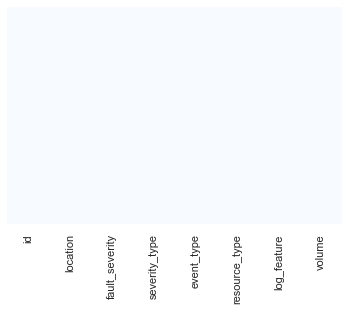

In [32]:
#con un heatmap de seaborn
sns.heatmap(train4.isnull(), yticklabels=False, cbar=False, cmap="Blues")

In [33]:
#Vamos a ver si hay valores faltantes
test4.isnull().sum()

id               0
location         0
severity_type    0
event_type       0
resource_type    0
log_feature      0
volume           0
dtype: int64

<AxesSubplot:>

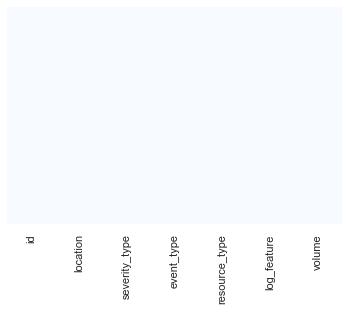

In [34]:
#con un heatmap de seaborn
sns.heatmap(test4.isnull(), yticklabels=False, cbar=False, cmap="Blues")

## Análisis Exploratorio de Datos (EDA)

In [35]:
#Para ver los valores únicos por columna:
print ('Uniques para location: ', train4.location.unique())
print ('Uniques para fault_severity: ', train4.fault_severity.unique())
print ('Uniques para severity_type: ', train4.severity_type.unique())
print ('Uniques para event_type: ', train4.event_type.unique())
print ('Uniques para resource_type: ', train4.resource_type.unique())
print ('Uniques para log_feature: ', train4.log_feature.unique())
print ('Uniques para volume: ', train4.volume.unique())

Uniques para location:  ['location 118' 'location 91' 'location 152' 'location 931' 'location 120'
 'location 664' 'location 640' 'location 122' 'location 263'
 'location 613' 'location 760' 'location 519' 'location 746'
 'location 1066' 'location 812' 'location 343' 'location 133'
 'location 976' 'location 948' 'location 808' 'location 894'
 'location 875' 'location 1024' 'location 166' 'location 687'
 'location 1016' 'location 707' 'location 978' 'location 775'
 'location 829' 'location 732' 'location 508' 'location 257'
 'location 116' 'location 830' 'location 491' 'location 253'
 'location 740' 'location 704' 'location 1089' 'location 653'
 'location 600' 'location 892' 'location 802' 'location 794'
 'location 477' 'location 684' 'location 895' 'location 496'
 'location 321' 'location 1107' 'location 1086' 'location 1099'
 'location 975' 'location 1019' 'location 342' 'location 744'
 'location 181' 'location 1052' 'location 696' 'location 1008'
 'location 798' 'location 777' 'locat

## Un vistazo general (A general view).

Para ver la cantidad de casos según **fault_severity**:

In [36]:
#Para visualizar los datos según l2
t4_fs = train4.groupby('fault_severity', sort=False, as_index=False).size().sort_values(by="size",ascending=False)
t4_fs

,fault_severity,size
1,0,4784
0,1,1871
2,2,726


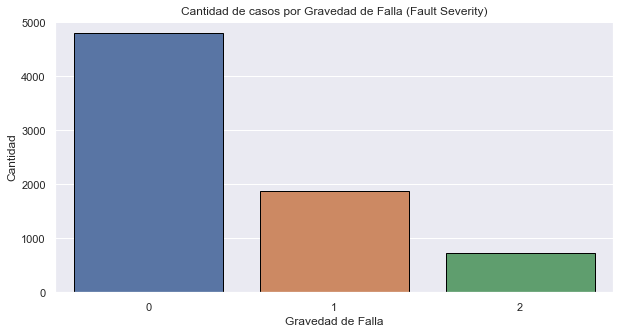

In [37]:
plt.figure(figsize=(10,5))
sns.countplot(data = train4, x='fault_severity', lw=1, edgecolor="black")
plt.title ('Cantidad de casos por Gravedad de Falla (Fault Severity)')
plt.xlabel('Gravedad de Falla')
plt.ylabel('Cantidad')
plt.show()

Podemos ver que hay mayor cantidad de no fallas que de fallas 1 o 2.

Para ver la cantidad de casos según **severity_type**:

In [38]:
t4_st = train4.groupby('severity_type', sort=False, as_index=False).size().sort_values(by="size",ascending=False)
t4_st

,severity_type,size
0,severity_type 2,3591
1,severity_type 1,3375
2,severity_type 4,388
3,severity_type 5,23
4,severity_type 3,4


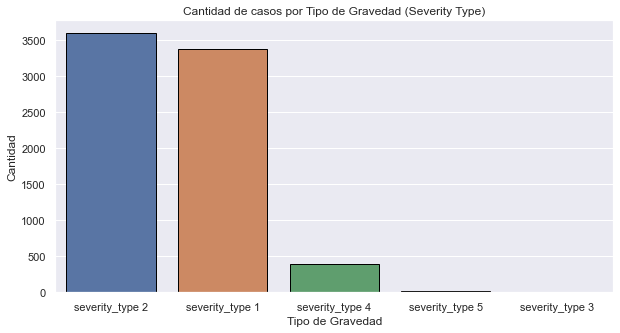

In [39]:
plt.figure(figsize=(10,5))
sns.countplot(data = train4, x='severity_type', lw=1, edgecolor="black")
plt.title ('Cantidad de casos por Tipo de Gravedad (Severity Type)')
plt.xlabel('Tipo de Gravedad')
plt.ylabel('Cantidad')
plt.show()

C on esta información podemos ver que las fallas que más se presentan son las de tipo 1 y 2. Las que gravedades tipo 4, 5 y 3 se presentan muy poco (en comparación con las tipo 1 y 2).

Para ver la cantidad de casos según **resource_type**:

In [40]:
t4_rt = train4.groupby('resource_type', sort=False, as_index=False).size().sort_values(by="size",ascending=False)
t4_rt

,resource_type,size
1,resource_type 8,3599
0,resource_type 2,3369
4,resource_type 6,121
2,resource_type 7,119
3,resource_type 4,57
5,resource_type 9,52
7,resource_type 3,32
8,resource_type 10,16
6,resource_type 1,15
9,resource_type 5,1


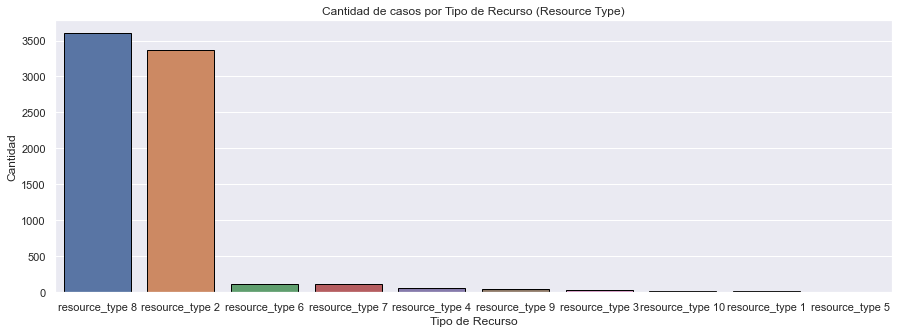

In [41]:
plt.figure(figsize=(15,5))
sns.barplot(data = t4_rt, x='resource_type', y= 'size',lw=1, edgecolor="black")
plt.title ('Cantidad de casos por Tipo de Recurso (Resource Type)')
plt.xlabel('Tipo de Recurso')
plt.ylabel('Cantidad')
plt.show()

Los tipos de recursos mas utilizados son: 2 y 8. Mientras que el resto de recursos tienen relativamente pocos casos.

Para ver la cantidad de casos según **location**:

In [42]:
t4_loc = train4.groupby('location', sort=False, as_index=False).size().sort_values(by="size",ascending=False)
t4_loc

,location,size
124,location 821,85
50,location 1107,78
118,location 734,75
179,location 126,71
60,location 1008,71
...,...,...
175,location 1122,1
729,location 813,1
731,location 589,1
736,location 117,1


Las 5 locaciones que tienen más casos son: 821, 1107, 734, 126 y 1008.

## Fallas tipo 1 (fault_severity = 1)

Vamos a analizar las fallas tipo 1 para ver qué podemos encontrar

In [43]:
fallas_tipo_1= train4[train4.fault_severity == 1]

In [44]:
fallas_tipo_1.head()

,id,location,fault_severity,severity_type,event_type,resource_type,log_feature,volume
0,14121,location 118,1,severity_type 2,event_type 34,resource_type 2,feature 312,19
2,14394,location 152,1,severity_type 2,event_type 35,resource_type 2,feature 221,1
3,8218,location 931,1,severity_type 1,event_type 15,resource_type 8,feature 80,9
8,3443,location 263,1,severity_type 2,event_type 34,resource_type 2,feature 312,1
9,13300,location 613,1,severity_type 1,event_type 54,resource_type 8,feature 71,1


In [45]:
fallas_tipo_1.shape

(1871, 8)

In [46]:
ft1_st = fallas_tipo_1.groupby('severity_type', sort=False, as_index=False).size().sort_values(by="size",ascending=False)
ft1_st

,severity_type,size
1,severity_type 1,1117
0,severity_type 2,693
2,severity_type 4,50
3,severity_type 5,11


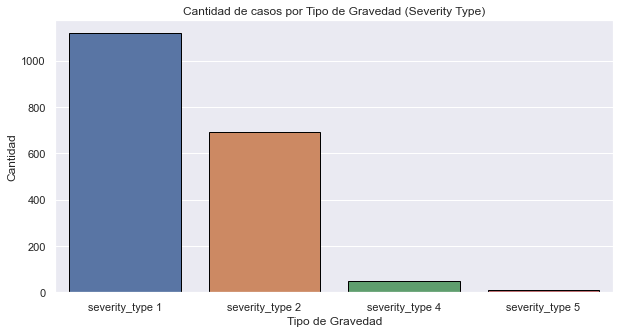

In [47]:
plt.figure(figsize=(10,5))
sns.barplot(data = ft1_st, x='severity_type', y='size', lw=1, edgecolor="black")
plt.title ('Cantidad de casos por Tipo de Gravedad (Severity Type)')
plt.xlabel('Tipo de Gravedad')
plt.ylabel('Cantidad')
plt.show()

Los mensajes que más se muestran son los tipo 1

In [48]:
ft1_rt = fallas_tipo_1.groupby('resource_type', sort=False, as_index=False).size().sort_values(by="size",ascending=False)
ft1_rt

,resource_type,size
1,resource_type 8,1096
0,resource_type 2,574
3,resource_type 6,71
2,resource_type 7,50
4,resource_type 4,29
5,resource_type 9,23
7,resource_type 3,17
6,resource_type 1,6
8,resource_type 10,5


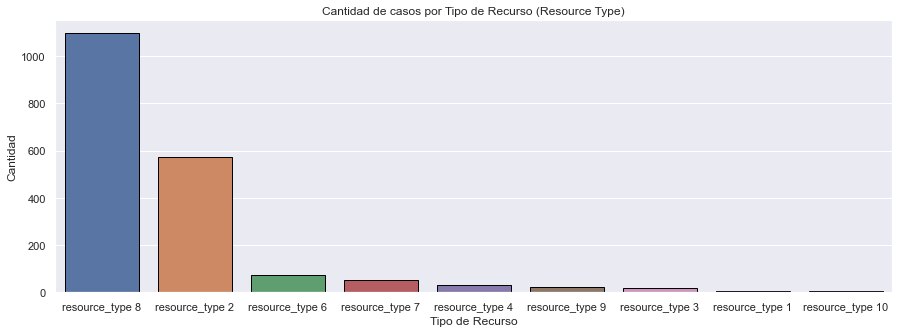

In [49]:
plt.figure(figsize=(15,5))
sns.barplot(data = ft1_rt, x='resource_type', y='size', lw=1, edgecolor="black")
plt.title ('Cantidad de casos por Tipo de Recurso (Resource Type)')
plt.xlabel('Tipo de Recurso')
plt.ylabel('Cantidad')
plt.show()

Las fallas con severidad 1, tienen mayor cantidad de recursos tipo 8 y 2.

In [50]:
ft1_loc = fallas_tipo_1.groupby('location', sort=False, as_index=False).size().sort_values(by="size",ascending=False)
ft1_loc

,location,size
42,location 821,27
17,location 1052,22
18,location 1008,21
77,location 1107,20
46,location 704,18
...,...,...
155,location 819,1
398,location 1118,1
148,location 26,1
402,location 248,1


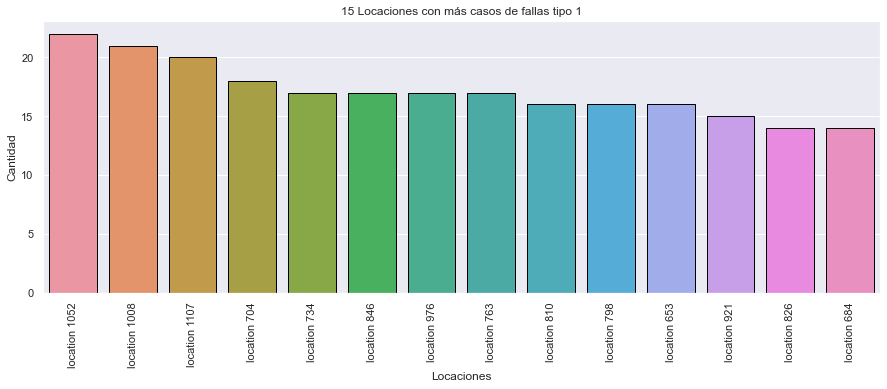

In [51]:
plt.figure(figsize=(15,5))
sns.barplot(data = ft1_loc[1:15], x='location', y='size', lw=1, edgecolor="black")
plt.title ('15 Locaciones con más casos de fallas tipo 1')
plt.xlabel('Locaciones')
plt.xticks(rotation=90)
plt.ylabel('Cantidad')
plt.show()

In [52]:
ft1_et = fallas_tipo_1.groupby('event_type', sort=False, as_index=False).size().sort_values(by="size",ascending=False)
ft1_et

,event_type,size
4,event_type 11,713
2,event_type 15,346
0,event_type 34,194
1,event_type 35,186
8,event_type 13,75
5,event_type 20,74
3,event_type 54,51
11,event_type 23,38
6,event_type 42,27
7,event_type 14,24


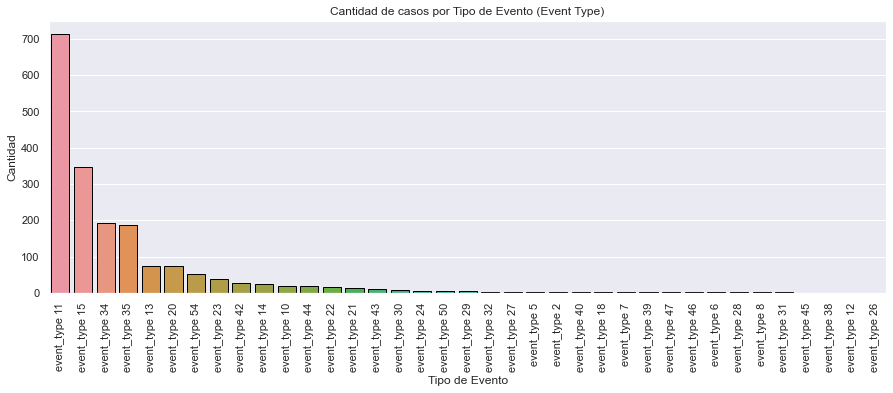

In [53]:
plt.figure(figsize=(15,5))
sns.barplot(data = ft1_et, x='event_type', y='size', lw=1, edgecolor="black")
plt.title ('Cantidad de casos por Tipo de Evento (Event Type)')
plt.xlabel('Tipo de Evento')
plt.xticks(rotation=90)
plt.ylabel('Cantidad')
plt.show()

## Fallas tipo 2 (fault_severity = 2)

Vamos a analizar las fallas tipo 1 para ver qué podemos encontrar

In [54]:
fallas_tipo_2= train4[train4.fault_severity == 2]

In [55]:
fallas_tipo_2.head()

,id,location,fault_severity,severity_type,event_type,resource_type,log_feature,volume
38,4311,location 704,2,severity_type 1,event_type 15,resource_type 8,feature 74,1
39,12261,location 1089,2,severity_type 1,event_type 11,resource_type 8,feature 170,11
41,14992,location 600,2,severity_type 2,event_type 15,resource_type 8,feature 203,1
42,967,location 892,2,severity_type 1,event_type 42,resource_type 2,feature 291,5
46,3945,location 684,2,severity_type 2,event_type 15,resource_type 8,feature 71,1


In [56]:
fallas_tipo_2.shape

(726, 8)

In [57]:
ft2_st = fallas_tipo_2.groupby('severity_type', sort=False, as_index=False).size().sort_values(by="size",ascending=False)
ft2_st

,severity_type,size
0,severity_type 1,480
1,severity_type 2,246


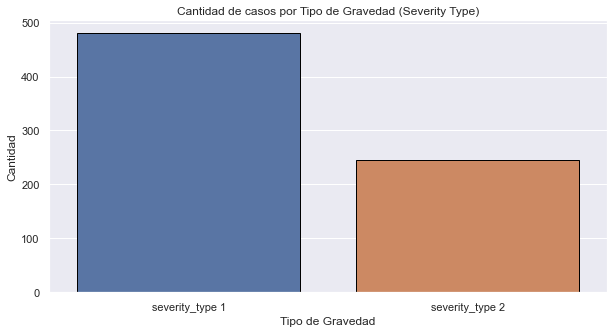

In [58]:
plt.figure(figsize=(10,5))
sns.barplot(data = ft2_st, x='severity_type', y='size', lw=1, edgecolor="black")
plt.title ('Cantidad de casos por Tipo de Gravedad (Severity Type)')
plt.xlabel('Tipo de Gravedad')
plt.ylabel('Cantidad')
plt.show()

In [59]:
ft2_rt = fallas_tipo_2.groupby('resource_type', sort=False, as_index=False).size().sort_values(by="size",ascending=False)
ft2_rt

,resource_type,size
0,resource_type 8,626
1,resource_type 2,76
5,resource_type 6,9
2,resource_type 1,5
3,resource_type 7,5
4,resource_type 4,1
6,resource_type 10,1
7,resource_type 3,1
8,resource_type 5,1
9,resource_type 9,1


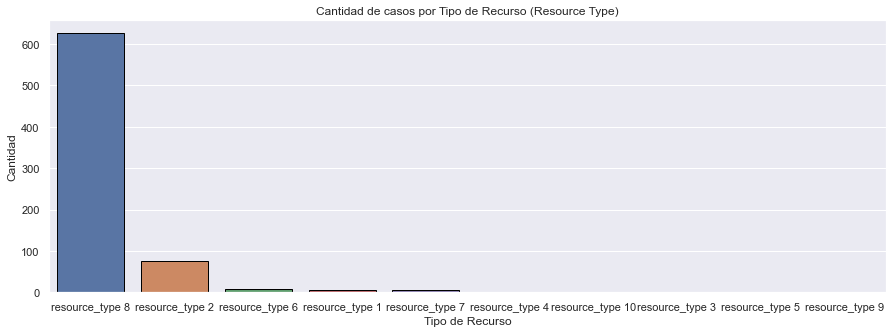

In [60]:
plt.figure(figsize=(15,5))
sns.barplot(data = ft2_rt, x='resource_type', y='size', lw=1, edgecolor="black")
plt.title ('Cantidad de casos por Tipo de Recurso (Resource Type)')
plt.xlabel('Tipo de Recurso')
plt.ylabel('Cantidad')
plt.show()

In [61]:
ft2_loc = fallas_tipo_2.groupby('location', sort=False, as_index=False).size().sort_values(by="size",ascending=False)
ft2_loc

,location,size
6,location 1107,33
28,location 1100,33
43,location 734,30
2,location 600,29
15,location 821,28
...,...,...
97,location 541,1
96,location 531,1
95,location 687,1
94,location 610,1


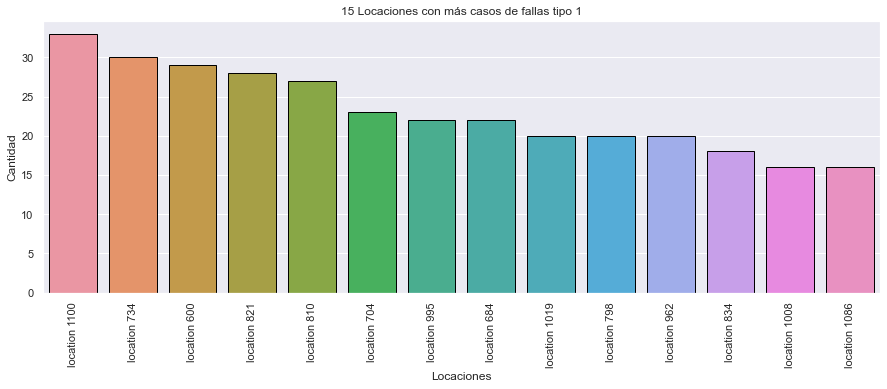

In [62]:
plt.figure(figsize=(15,5))
sns.barplot(data = ft2_loc[1:15], x='location', y='size', lw=1, edgecolor="black")
plt.title ('15 Locaciones con más casos de fallas tipo 1')
plt.xlabel('Locaciones')
plt.xticks(rotation=90)
plt.ylabel('Cantidad')
plt.show()

In [63]:
ft2_et = fallas_tipo_2.groupby('event_type', sort=False, as_index=False).size().sort_values(by="size",ascending=False)
ft2_et

,event_type,size
0,event_type 15,370
1,event_type 11,241
4,event_type 54,26
7,event_type 44,23
5,event_type 13,14
2,event_type 42,10
6,event_type 20,9
9,event_type 43,6
10,event_type 14,6
21,event_type 22,3


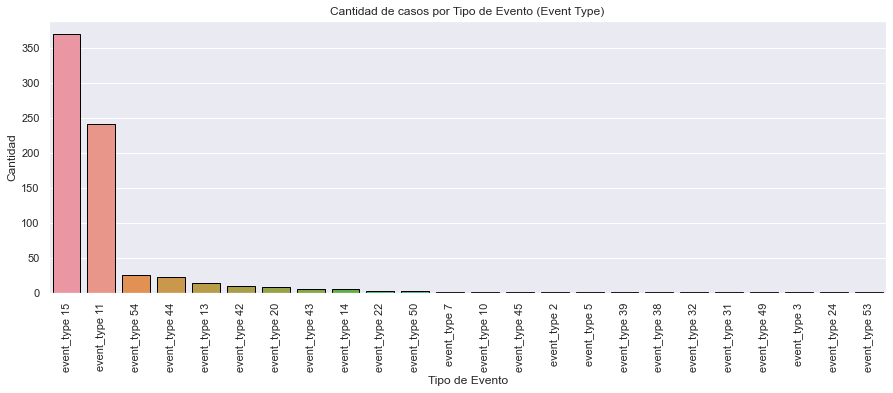

In [64]:
plt.figure(figsize=(15,5))
sns.barplot(data = ft2_et, x='event_type', y='size', lw=1, edgecolor="black")
plt.title ('Cantidad de casos por Tipo de Evento (Event Type)')
plt.xlabel('Tipo de Evento')
plt.xticks(rotation=90)
plt.ylabel('Cantidad')
plt.show()

Podemos ver que los casos que registran fallas tipo 1 y los casos que registran fallas tipo 2 son diferentes en los tipos de eventos, locaciones, tipo de severidad.

Mientras que para el tipo de recurso son iguales en ambos casos (8 y 2)

## Preprocesamiento de datos (Data Preprocesing).

In [65]:
train4.head()

,id,location,fault_severity,severity_type,event_type,resource_type,log_feature,volume
0,14121,location 118,1,severity_type 2,event_type 34,resource_type 2,feature 312,19
1,9320,location 91,0,severity_type 2,event_type 34,resource_type 2,feature 315,200
2,14394,location 152,1,severity_type 2,event_type 35,resource_type 2,feature 221,1
3,8218,location 931,1,severity_type 1,event_type 15,resource_type 8,feature 80,9
4,14804,location 120,0,severity_type 1,event_type 34,resource_type 2,feature 134,1


Pasamos los datos a valores:

In [66]:
train4['location']= train4.location.str.extract('(\d+)', expand=False)
train4['location']= train4.location.astype(int)

train4['severity_type']= train4.severity_type.str.extract('(\d+)', expand=False)
train4['severity_type']= train4.severity_type.astype(int)

train4['event_type']= train4.event_type.str.extract('(\d+)', expand=False)
train4['event_type']= train4.event_type.astype(int)

train4['resource_type']= train4.resource_type.str.extract('(\d+)', expand=False)
train4['resource_type']= train4.resource_type.astype(int)

train4['log_feature']= train4.log_feature.str.extract('(\d+)', expand=False)
train4['log_feature']= train4.log_feature.astype(int)

train4.head()

,id,location,fault_severity,severity_type,event_type,resource_type,log_feature,volume
0,14121,118,1,2,34,2,312,19
1,9320,91,0,2,34,2,315,200
2,14394,152,1,2,35,2,221,1
3,8218,931,1,1,15,8,80,9
4,14804,120,0,1,34,2,134,1


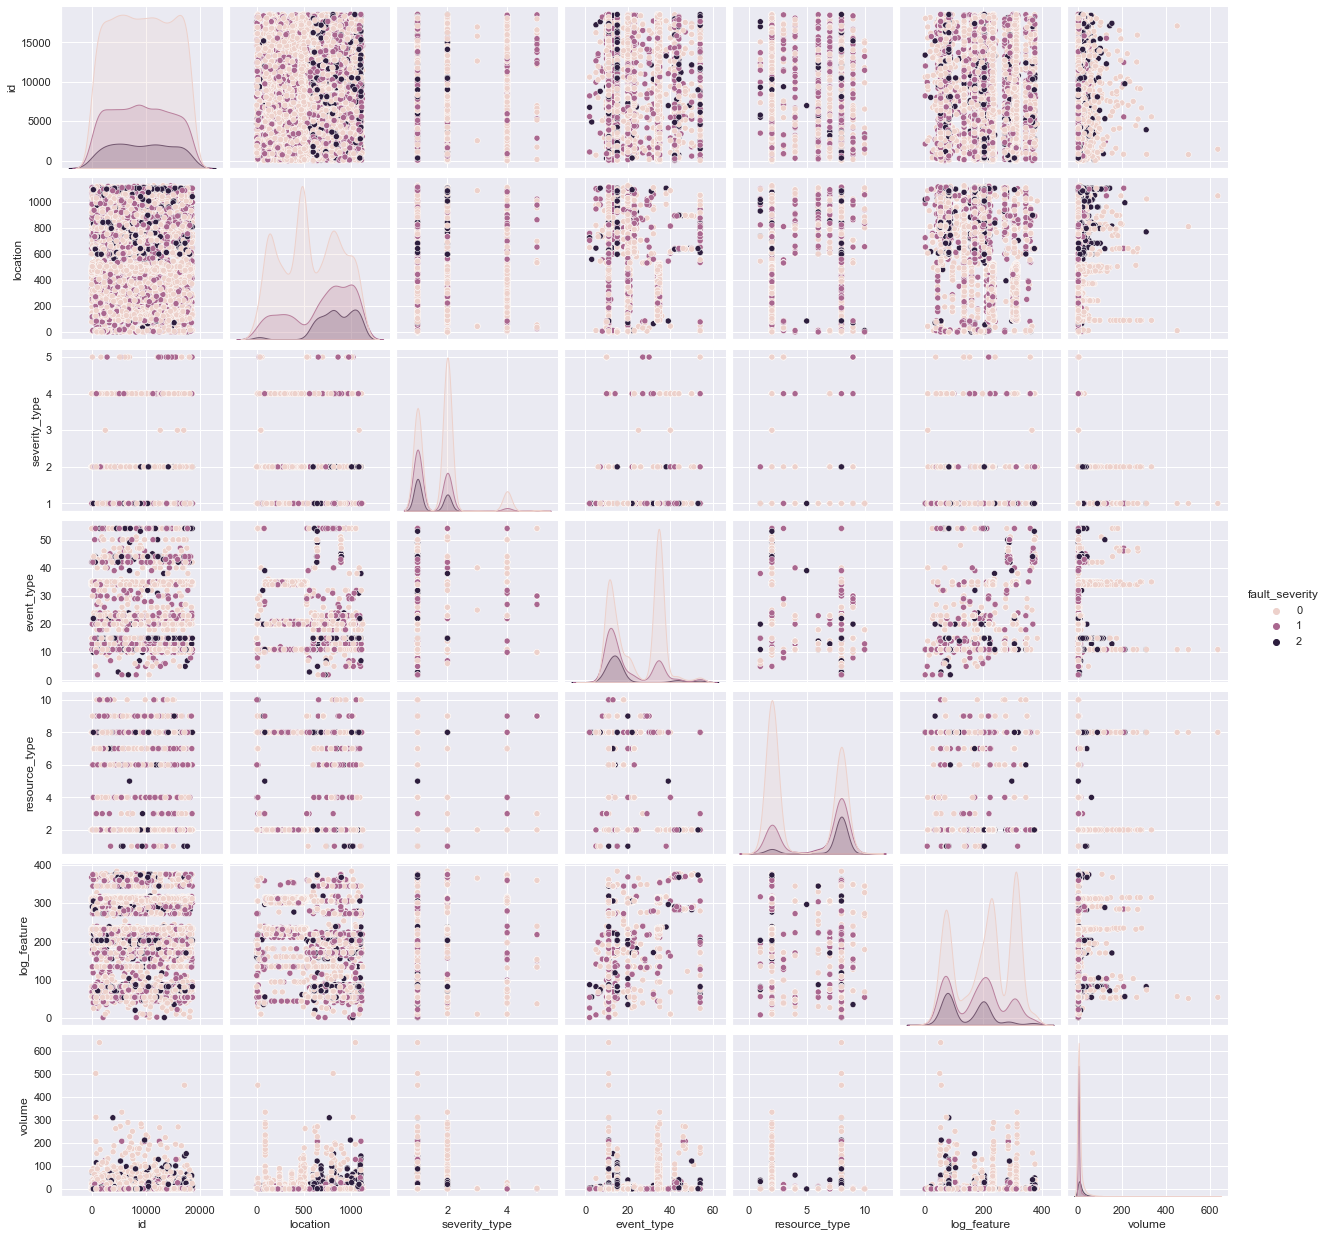

In [67]:
sns.pairplot(train4, hue = 'fault_severity')

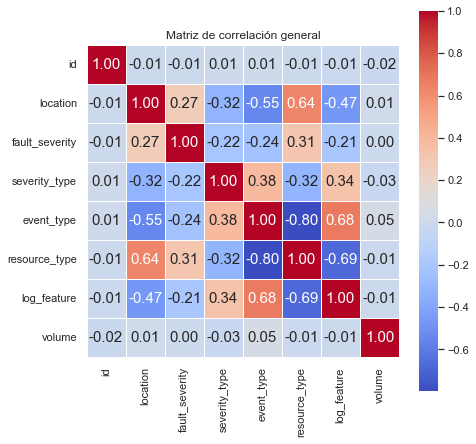

In [68]:
plt.figure(figsize=(7,7))

sns.heatmap(train4.corr(), cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           cmap= 'coolwarm', linewidths=.5)
plt.xticks(rotation = 90)
plt.title ("Matriz de correlación general")
plt.show()

In [69]:
X= train4.drop(['id', 'fault_severity'], axis=1)

In [70]:
X.head()

,location,severity_type,event_type,resource_type,log_feature,volume
0,118,2,34,2,312,19
1,91,2,34,2,315,200
2,152,2,35,2,221,1
3,931,1,15,8,80,9
4,120,1,34,2,134,1


In [71]:
X.describe()

,location,severity_type,event_type,resource_type,log_feature,volume
count,7381.000000,7381.000000,7381.000000,7381.000000,7381.000000,7381.000000
mean,624.313779,1.657770,22.869936,5.156618,192.530822,8.580409
std,320.622091,0.760966,11.853779,2.962845,95.446880,23.539402
min,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
25%,374.000000,1.000000,11.000000,2.000000,82.000000,1.000000
50%,665.000000,2.000000,15.000000,7.000000,203.000000,2.000000
75%,893.000000,2.000000,34.000000,8.000000,290.000000,7.000000
max,1126.000000,5.000000,54.000000,10.000000,384.000000,636.000000


In [72]:
y= train4.fault_severity

In [73]:
print ('X shape: ', X.shape)
print ('y shape: ', y.shape)

X shape:  (7381, 6)
y shape:  (7381,)


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.75)

In [75]:
print ('X_train shape: ', X_train.shape)
print ('y_train shape: ', y_train.shape)
print ('X_test shape: ', X_test.shape)
print ('y_test shape: ', y_test.shape)

X_train shape:  (1845, 6)
y_train shape:  (1845,)
X_test shape:  (5536, 6)
y_test shape:  (5536,)


Preprocesamos para predecir con el dataset de **test**:

In [76]:
test4.head()

,id,location,severity_type,event_type,resource_type,log_feature,volume
0,11066,location 481,severity_type 2,event_type 35,resource_type 2,feature 230,24
1,18000,location 962,severity_type 1,event_type 11,resource_type 8,feature 203,9
2,16964,location 491,severity_type 2,event_type 35,resource_type 2,feature 235,10
3,4795,location 532,severity_type 5,event_type 27,resource_type 3,feature 240,1
4,3392,location 600,severity_type 2,event_type 15,resource_type 8,feature 82,6


In [77]:
test4['location']= test4.location.str.extract('(\d+)', expand=False)
test4['location']= test4.location.astype(int)

test4['severity_type']= test4.severity_type.str.extract('(\d+)', expand=False)
test4['severity_type']= test4.severity_type.astype(int)

test4['event_type']= test4.event_type.str.extract('(\d+)', expand=False)
test4['event_type']= test4.event_type.astype(int)

test4['resource_type']= test4.resource_type.str.extract('(\d+)', expand=False)
test4['resource_type']= test4.resource_type.astype(int)

test4['log_feature']= test4.log_feature.str.extract('(\d+)', expand=False)
test4['log_feature']= test4.log_feature.astype(int)

test4.head()

,id,location,severity_type,event_type,resource_type,log_feature,volume
0,11066,481,2,35,2,230,24
1,18000,962,1,11,8,203,9
2,16964,491,2,35,2,235,10
3,4795,532,5,27,3,240,1
4,3392,600,2,15,8,82,6


In [78]:
X_predic = test4.drop('id', axis=1)

In [79]:
X_predic.head()

,location,severity_type,event_type,resource_type,log_feature,volume
0,481,2,35,2,230,24
1,962,1,11,8,203,9
2,491,2,35,2,235,10
3,532,5,27,3,240,1
4,600,2,15,8,82,6


In [80]:
X_predic.shape

(11171, 6)

### Elección de Métricas (KPIs de evaluación de modelos)

Para un `modelo de clasificación` vamos a utilizar la `matriz de confusión` que nos muestra la forma en que clasificó el modelo que estamos entrenando. A partir de la matriz vamos a revisar 4 indicadores y prestar especial atención a 2 de ellos:

**Accuracy (Exactitud):** Nos dice qué tan bien predijo el modelo. Se representa como  la proporción de resultados verdaderos (tanto verdaderos positivos (TP) como verdaderos negativos (TN)) dividido entre el número total de casos examinados.

En forma práctica,  el accuracy es  la cantidad de predicciones que fueron correctas.

$$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$$

**Precision (Precisión):**  Se refiere a la dispersión del conjunto de valores obtenidos a partir de mediciones repetidas de una magnitud. Cuanto menor es la dispersión mayor la precisión. Se representa por la proporción de verdaderos positivos dividido entre todos los resultados positivos (tanto verdaderos positivos, como falsos positivos).En forma práctica es  el porcentaje de casos positivos detectados.

$$Precision = \frac{VP}{VP+FP}$$

**Recall (Sensibilidad):** Es un valor que nos indican la capacidad de nuestro modelo para discriminar los casos positivos, de los negativos. Es la proporción de casos positivos que fueron correctamente identificadas por el algoritmo.

$$Recall = \frac{VP}{VP+FN}$$  

O lo que sería igual :  "Verdaderos positivos / Total de enfermos" (en el área de la salud se dice que la sensibilidad es la capacidad de de poder detectar correctamente la enfermedad entre los enfermos).

**F1 Score:** Es otra métrica muy empleada porque resume la precisión y recall en una sola métrica. Por ello es de gran utilidad cuando la distribución de las clases es desigual (datasets desbalanceados).

$$F1 \ score \ =  \frac{2 * (Recall * Precision)}{(Recall + Precision)}$$

**Función de pérdida (log_loss):**  Log loss mide el rendimiento de un clasificador donde el resultado pronosticado es un valor de probabilidad entre 0 y 1.Es evidente que los clasificadores más idóneos tienen valores progresivamente más pequeños de Log loss. Por lo tanto, el clasificador con menor Log loss tiene una mejor precisión.

Creamos una función para evaluar los resultados:

In [81]:
def resultados (y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, cbar= False,  square= True, annot=True, fmt= '.0f', annot_kws={'size': 15},
           cmap= 'coolwarm', linewidths=.5);
    plt.title('Matriz de Confusión')
    plt.ylabel('Predicción')
    plt.xlabel('Clase Real')
    plt.show()
    print (classification_report(y_test, y_pred))

## Modelo Benchmark

### Decision Tree

In [82]:
tree= DecisionTreeClassifier(random_state=42)

In [83]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [84]:
y_pred_tree= tree.predict(X_test)

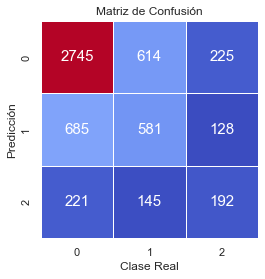

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      3584
           1       0.43      0.42      0.43      1394
           2       0.35      0.34      0.35       558

    accuracy                           0.64      5536
   macro avg       0.51      0.51      0.51      5536
weighted avg       0.63      0.64      0.63      5536



In [85]:
resultados (y_test, y_pred_tree)

In [86]:
#Predecimos para ver la función de pérdida (log_loss)
y_prob_tree = tree.predict_proba(X_test)

In [87]:
loss_dt= log_loss(y_test, y_prob_tree)
loss_dt

12.473282404878194

### KNN

In [88]:
knn = KNeighborsClassifier()

In [89]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [90]:
y_pred_knn= knn.predict(X_test)

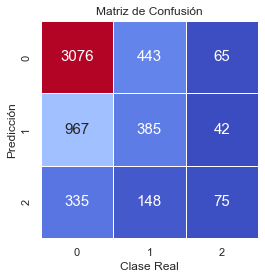

              precision    recall  f1-score   support

           0       0.70      0.86      0.77      3584
           1       0.39      0.28      0.32      1394
           2       0.41      0.13      0.20       558

    accuracy                           0.64      5536
   macro avg       0.50      0.42      0.43      5536
weighted avg       0.60      0.64      0.60      5536



In [91]:
resultados (y_test, y_pred_knn)

In [92]:
y_prob_knn= knn.predict_proba(X_test)

In [93]:
loss_knn= log_loss(y_test, y_prob_knn)
loss_knn

2.9496702603234217

### Random Forest

In [94]:
forest = RandomForestClassifier(random_state=42)

In [95]:
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [96]:
y_pred_forest= forest.predict(X_test)

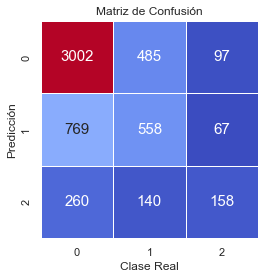

              precision    recall  f1-score   support

           0       0.74      0.84      0.79      3584
           1       0.47      0.40      0.43      1394
           2       0.49      0.28      0.36       558

    accuracy                           0.67      5536
   macro avg       0.57      0.51      0.53      5536
weighted avg       0.65      0.67      0.66      5536



In [97]:
resultados (y_test, y_pred_forest)

In [98]:
y_prob_forest= forest.predict_proba(X_test)

In [99]:
loss_forest= log_loss(y_test, y_prob_forest)
loss_forest

0.8774637517408173

### Logistic Regression 

In [100]:
lr= LogisticRegression(random_state=42, class_weight='balanced', multi_class='auto')

In [101]:
lr.fit(X_train, y_train)

/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', random_state=42)

In [102]:
y_pred_lr= lr.predict(X_test)

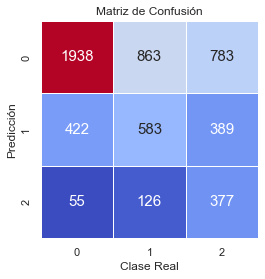

              precision    recall  f1-score   support

           0       0.80      0.54      0.65      3584
           1       0.37      0.42      0.39      1394
           2       0.24      0.68      0.36       558

    accuracy                           0.52      5536
   macro avg       0.47      0.54      0.47      5536
weighted avg       0.64      0.52      0.55      5536



In [103]:
resultados(y_test, y_pred_lr)

In [104]:
y_prob_lr= lr.predict_proba(X_test)

In [105]:
loss_lr= log_loss(y_test, y_prob_lr)
loss_lr

1.0182225809469834

## Mejorando el mejor modelo (Random Forest)

El mejor modelo fue el de Random Forest, vamos a mejorarlo utilizando GridSearchCV.

In [106]:
#Hacemos la grilla para Grid Search:
param_grid = {'n_estimators': [200, 300, 400, 500],   
              'min_samples_split': [2,3,4,5],    
              'min_samples_leaf':[1,3,5]}   

In [107]:
model = GridSearchCV(forest, param_grid=param_grid, cv=5)

In [108]:
model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [200, 300, 400, 500]})

In [109]:
print("Mejores parametros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

Mejores parametros: {'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 400}
Mejor Score: 0.7062330623306233



Creamos un modelo nuevo con los mejores parámetros.

In [128]:
forest2= RandomForestClassifier(min_samples_leaf= 5, min_samples_split= 2, n_estimators= 400, random_state=42)

In [129]:
forest2.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=5, n_estimators=400, random_state=42)

In [130]:
y_pred_forest2= forest2.predict(X_test)

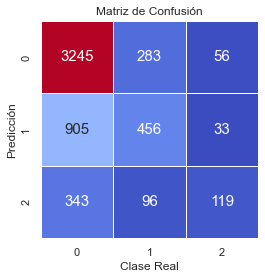

              precision    recall  f1-score   support

           0       0.72      0.91      0.80      3584
           1       0.55      0.33      0.41      1394
           2       0.57      0.21      0.31       558

    accuracy                           0.69      5536
   macro avg       0.61      0.48      0.51      5536
weighted avg       0.66      0.69      0.65      5536



In [131]:
resultados (y_test, y_pred_forest2)

In [132]:
y_prob_forest2= forest2.predict_proba(X_test)

In [133]:
loss_forest2= log_loss(y_test, y_prob_forest2)
loss_forest2

0.656586448587273

Para ver los estimadores:

In [134]:
forest2.feature_importances_

array([0.30199968, 0.07820803, 0.12408673, 0.08417851, 0.24283826,
       0.16868878])

In [135]:
cols_model= ['location','severity_type','event_type','resource_type','log_feature','volume']
cols_model

['location',
 'severity_type',
 'event_type',
 'resource_type',
 'log_feature',
 'volume']

In [136]:
feature_importance= pd.DataFrame(list(zip(cols_model, forest2.feature_importances_.transpose())), columns = ['Col','Importance']).sort_values(by="Importance",ascending=False)
feature_importance

,Col,Importance
0,location,0.302000
4,log_feature,0.242838
5,volume,0.168689
2,event_type,0.124087
3,resource_type,0.084179
1,severity_type,0.078208


## Predicción con el dataset de test

In [137]:
X_predic.head()

,location,severity_type,event_type,resource_type,log_feature,volume
0,481,2,35,2,230,24
1,962,1,11,8,203,9
2,491,2,35,2,235,10
3,532,5,27,3,240,1
4,600,2,15,8,82,6


In [146]:
prediccion= forest2.predict_proba(X_predic)
prediccion

array([[9.90559237e-01, 9.42328095e-03, 1.74825175e-05],
       [2.52575297e-01, 4.15747347e-01, 3.31677356e-01],
       [9.89992348e-01, 9.53251874e-03, 4.75132791e-04],
       ...,
       [2.59315442e-01, 6.09606102e-01, 1.31078456e-01],
       [9.65523270e-01, 3.42606128e-02, 2.16117216e-04],
       [5.62059947e-01, 4.34433713e-01, 3.50633972e-03]])

In [147]:
#Lo pasamos a dataframe
prediccion_data= pd.DataFrame(prediccion,columns=['predict_0', 'predict_1', 'predict_2'])
prediccion_data

,predict_0,predict_1,predict_2
0,0.990559,0.009423,0.000017
1,0.252575,0.415747,0.331677
2,0.989992,0.009533,0.000475
3,0.694142,0.292027,0.013831
4,0.601598,0.262598,0.135804
...,...,...,...
11166,0.516917,0.389961,0.093123
11167,0.617283,0.309011,0.073706
11168,0.259315,0.609606,0.131078
11169,0.965523,0.034261,0.000216


In [148]:
#Lo juntamos con el id
submission= pd.concat([test4[['id']],prediccion_data],axis=1)
submission

,id,predict_0,predict_1,predict_2
0,11066,0.990559,0.009423,0.000017
1,18000,0.252575,0.415747,0.331677
2,16964,0.989992,0.009533,0.000475
3,4795,0.694142,0.292027,0.013831
4,3392,0.601598,0.262598,0.135804
...,...,...,...,...
11166,14806,0.516917,0.389961,0.093123
11167,1825,0.617283,0.309011,0.073706
11168,2374,0.259315,0.609606,0.131078
11169,7277,0.965523,0.034261,0.000216


In [150]:
#Lo guardamos en el archivo:
submission.to_csv('submission3.csv',index=False,header=True)

In [140]:
#Pasamos los datos a predicciones (1s y 0s)
for i in range(len(prediccion_data)):
    if prediccion_data['predict_0'].iloc[i] > prediccion_data['predict_1'].iloc[i] and prediccion_data['predict_2'].iloc[i]:
        prediccion_data['predict_0'].iloc[i]=1
        prediccion_data['predict_1'].iloc[i]=0
        prediccion_data['predict_2'].iloc[i]=0
    else:
        prediccion_data['predict_0'].iloc[i]=0
        if prediccion_data['predict_1'].iloc[i] > prediccion_data['predict_2'].iloc[i]:
            prediccion_data['predict_1'].iloc[i]=1
            prediccion_data['predict_2'].iloc[i]=0
        else:
            prediccion_data['predict_1'].iloc[i]=0
            prediccion_data['predict_2'].iloc[i]=1
            

In [141]:
prediccion_data

,predict_0,predict_1,predict_2
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
11166,1.0,0.0,0.0
11167,1.0,0.0,0.0
11168,0.0,1.0,0.0
11169,1.0,0.0,0.0


In [142]:
#Pasamos los datos a int
prediccion_data= prediccion_data[['predict_0', 'predict_1', 'predict_2']].astype(int)
prediccion_data.head(20)

,predict_0,predict_1,predict_2
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0
5,0,1,0
6,0,1,0
7,1,0,0
8,1,0,0
9,1,0,0


In [145]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11171 entries, 0 to 11170
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id         11171 non-null  int64
 1   predict_0  11171 non-null  int64
 2   predict_1  11171 non-null  int64
 3   predict_2  11171 non-null  int64
dtypes: int64(4)
memory usage: 349.2 KB
